In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt

## Setup
The dataset I used is the Fashion MNIST dataset. In order to tune the self-supervised hyperparameters, I split the training data into the training set and two validation sets. One validation set is for verifying hyperparameters on clean data at training time, and the other is for verifying hyperparameters on corrupted data at test time.

In [2]:
# General parameters
RUN_TEST = True  # If done with tuning model, set to True
USE_GPU = True
batch_size = 64

In [3]:
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('using device:', device)

using device: cuda


In [4]:
from torchvision import datasets

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [5]:
# Dataloaders
NUM_VAL = 10000
NUM_TOTAL = 60000

# To tune test-time training, I split the training set into two validation sets, one for clean validation 
# and one for test-time training validation

# Validation set used during training to tune network hyperparameters
loader_val_clean = DataLoader(train_data, batch_size=batch_size, num_workers=4,
                          sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

# Validation set used during TTT to tune self-supervised hyperparameters
loader_val_ttt = DataLoader(train_data, batch_size=batch_size, num_workers=4,
                          sampler=sampler.SubsetRandomSampler(range(NUM_VAL, NUM_VAL*2)))

loader_train = DataLoader(train_data, batch_size=batch_size, num_workers=4,
                          sampler=sampler.SubsetRandomSampler(range(NUM_VAL*2, NUM_TOTAL)))

loader_test = DataLoader(test_data, batch_size=batch_size, num_workers=4)

## Training and Validation
The baseline ResNet and the self-supervised test-time training SSResNet classes can be found in the `models` folder. Their structures are similar, the only difference being the addition of the second self-supervised head on the SSResNet. Otherwise, the feature extractor and the main head in series for the SSResNet is equivalent to the base ResNet.

In [6]:
from training_testing.training import train

# Training parameters
retrain = True
lr = 3e-3
weight_decay = 5e-4
epochs = 10
momentum = 0.9

In [7]:
# Training the SSResNet
from models.SSResNet import SSResNet

if retrain:  # Prevent from retraining when not needed
    model_ss = SSResNet().to(device=device)
    optimizer = optim.SGD(model_ss.parameters(),lr=lr,momentum=momentum, weight_decay=weight_decay)
    train(model_ss,optimizer,loader_train,loader_val_clean,epochs=epochs,two_head=True)

Epoch 0, Iteration 100, loss = 2.6632
Checking accuracy on validation set
Got 4783 / 10000 correct (47.83)

Epoch 0, Iteration 200, loss = 1.7388
Checking accuracy on validation set
Got 6011 / 10000 correct (60.11)

Epoch 0, Iteration 300, loss = 1.1543
Checking accuracy on validation set
Got 6963 / 10000 correct (69.63)

Epoch 0, Iteration 400, loss = 0.9815
Checking accuracy on validation set
Got 7333 / 10000 correct (73.33)

Epoch 0, Iteration 500, loss = 0.8046
Checking accuracy on validation set
Got 7466 / 10000 correct (74.66)

Epoch 0, Iteration 600, loss = 0.8949
Checking accuracy on validation set
Got 7456 / 10000 correct (74.56)

Epoch 1, Iteration 100, loss = 0.6602
Checking accuracy on validation set
Got 7633 / 10000 correct (76.33)

Epoch 1, Iteration 200, loss = 0.6471
Checking accuracy on validation set
Got 7755 / 10000 correct (77.55)

Epoch 1, Iteration 300, loss = 0.5377
Checking accuracy on validation set
Got 7852 / 10000 correct (78.52)

Epoch 1, Iteration 400, loss

In [8]:
# Training the ResNet baseline
from models.ResNet import ResNet

if retrain:  # Prevent from retraining when not needed
    model_resnet = ResNet().to(device=device)
    optimizer = optim.SGD(model_resnet.parameters(),lr=lr,momentum=momentum, weight_decay=weight_decay)
    train(model_resnet,optimizer,loader_train,loader_val_clean,epochs=epochs,two_head=False)

Epoch 0, Iteration 100, loss = 1.2360
Checking accuracy on validation set
Got 4809 / 10000 correct (48.09)

Epoch 0, Iteration 200, loss = 0.9997
Checking accuracy on validation set
Got 6665 / 10000 correct (66.65)

Epoch 0, Iteration 300, loss = 0.7452
Checking accuracy on validation set
Got 6264 / 10000 correct (62.64)

Epoch 0, Iteration 400, loss = 0.6453
Checking accuracy on validation set
Got 7437 / 10000 correct (74.37)

Epoch 0, Iteration 500, loss = 0.6086
Checking accuracy on validation set
Got 7516 / 10000 correct (75.16)

Epoch 0, Iteration 600, loss = 0.6661
Checking accuracy on validation set
Got 7524 / 10000 correct (75.24)

Epoch 1, Iteration 100, loss = 0.5151
Checking accuracy on validation set
Got 7698 / 10000 correct (76.98)

Epoch 1, Iteration 200, loss = 0.6286
Checking accuracy on validation set
Got 7951 / 10000 correct (79.51)

Epoch 1, Iteration 300, loss = 0.6421
Checking accuracy on validation set
Got 8105 / 10000 correct (81.05)

Epoch 1, Iteration 400, loss

In [9]:
# Validate on some gaussian noise to test robustness
from utils.transforms import * 

gaussian_noise = GaussianNoise(std=0.25)

In [40]:
# SSResNet TTT Validation on both clean and noisy data
from training_testing.testing import check_accuracy
import copy

print('Validating on clean data...')
model_copy_ss = copy.deepcopy(model_ss)

ss_optimizing_params = list(model_copy_ss.shared_branch.parameters()) + list(model_copy_ss.ss_head.parameters())
optimizer = optim.SGD(ss_optimizing_params,lr=lr,momentum=0, weight_decay=0)

check_accuracy(loader_val_ttt,model_copy_ss,two_head=True,ttt=True,optimizer=optimizer)
print()


print('Validating on noisy data...')
model_copy_ss = copy.deepcopy(model_ss)

ss_optimizing_params = list(model_copy_ss.shared_branch.parameters()) + list(model_copy_ss.ss_head.parameters())
optimizer = optim.SGD(ss_optimizing_params,lr=lr,momentum=0, weight_decay=0)

check_accuracy(loader_val_ttt,model_copy_ss,two_head=True,ttt=True,optimizer=optimizer,transform=gaussian_noise)

Validating on clean data...
Checking accuracy on validation set
Got 8838 / 10000 correct (88.38)

Validating on noisy data...
Checking accuracy on validation set
Got 7401 / 10000 correct (74.01)


0.7401

In [41]:
# SSResNet (no TTT) Validation
model_copy_ss = copy.deepcopy(model_ss)

print('Validating on clean data...')
check_accuracy(loader_val_ttt,model_copy_ss,two_head=True)
print()

print('Validating on noisy data...')
check_accuracy(loader_val_ttt,model_copy_ss,two_head=True,transform=gaussian_noise)

Validating on clean data...
Checking accuracy on validation set
Got 8929 / 10000 correct (89.29)

Validating on noisy data...
Checking accuracy on validation set
Got 3864 / 10000 correct (38.64)


0.3864

In [42]:
# ResNet baseline Validation
optimizer = optim.SGD(model_resnet.parameters(),lr=lr,momentum=0.9, weight_decay=5e-4)

print('Validating on clean data...')
check_accuracy(loader_val_ttt,model_resnet,two_head=False,optimizer=optimizer)
print()

print('Validating on noisy data...')
check_accuracy(loader_val_ttt,model_resnet,two_head=False,optimizer=optimizer,transform=gaussian_noise)

Validating on clean data...
Checking accuracy on validation set
Got 8854 / 10000 correct (88.54)

Validating on noisy data...
Checking accuracy on validation set
Got 4126 / 10000 correct (41.26)


0.4126

#### Training Summary
The results of the clean vs. noisy inputs shows that test-time training is much more robust to Gaussian noise compared to the base ResNet and joint training without test-time training, i.e. testing on SSResNet with no self-supervised learning. However, the similarity between the joint training and base ResNet shows that the addition of the self-supervised head and its subsequent effect on training is negligible in terms of how it affects validation accuracy. 

Below is a visualization of the auxiliary task to get some insight on what the self-supervised head is training on. It uses this rotation task to update its own parameters and the parameters of the shared feature extractor at test-time. 

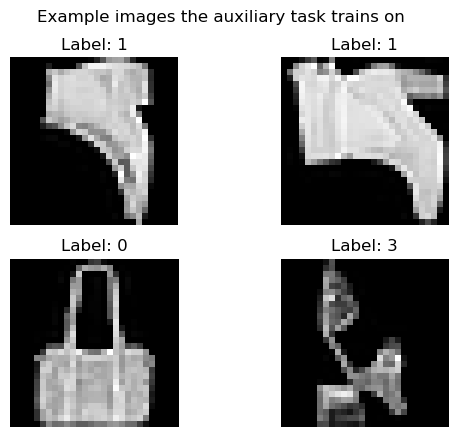

In [50]:
# Visualize auxiliary task, labels 0-1-2-3 correspond to 0-90-180-270 degree CCW rotations
from utils.RandomRotation90deg import *

batch,_ = next(iter(loader_train))
auxiliary_task = RandomRotation90deg()
batch,labels = auxiliary_task(batch)

fig, ax = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(batch[2*i+j].squeeze(),cmap='gray')
        ax[i,j].set_title(f'Label: {labels[2*i+j]}')
        ax[i,j].axis('off')
        
fig.suptitle("Example images the auxiliary task trains on")
plt.show()

## Testing and Experiments
To test my method, I wrote multiple functions to simulate various different types of noise or image corruption. They are as follows: Gaussian noise, Impulse/Salt and Pepper noise, image pixelation, image blurring, and JPEG compression. While tuning hyperparameters, I used a subset of the training data that was not seen during the clean training/validation phase and corrupted it with these noises at different intensities.

For this first experiment, I varied the error that each test batch received, increasing the intensity with each batch at a linear rate for both Gaussian and Salt and Pepper noise. To ensure the model is always fresh from the training phase, I used deep copies to keep a record of the original model parameters that can be used to refresh the model without needing to spend so much GPU power retraining it. I plotted the cumulative error of all examples seen so far on each classifier. As examples, I also display some examples of corrupted images. The low and high intensity corrupted images are not necessarily from the same image. 

To clarify, object recognition refers to the baseline ResNet, using the same layers as the self-supervised ResNet, but having only one head, not two. The joint training refers to using the self-supervised ResNet in a non-TTT (test-time training) capacity.


In [13]:
# After validation finishes, do final plots either with appropriate set
if RUN_TEST:
    loader = loader_test
else:
    loader = loader_val_ttt

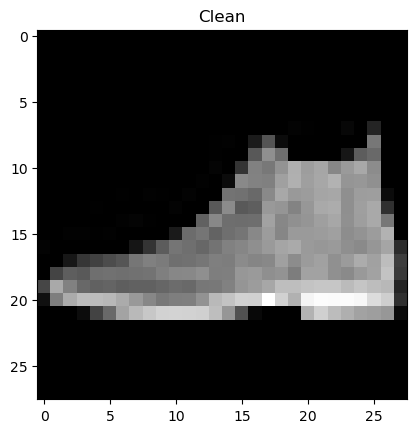

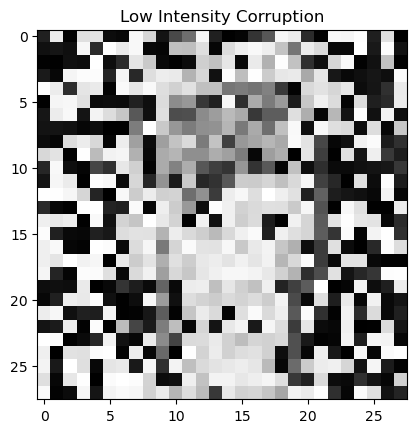

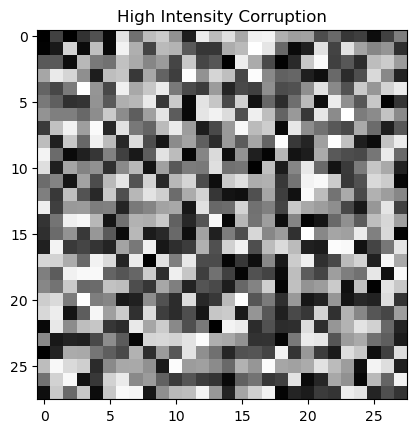

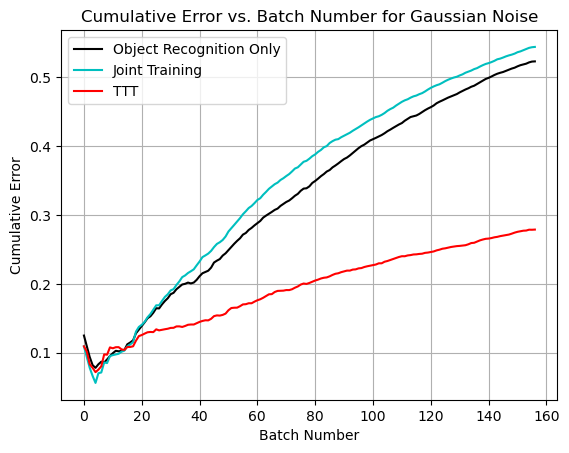

In [14]:
# Increasing gaussian noise as batches come in
from training_testing.testing import test_increasing_noise

model_copy_ss = copy.deepcopy(model_ss)
ss_optimizing_params = list(model_copy_ss.shared_branch.parameters()) + list(model_copy_ss.ss_head.parameters())
optimizer = optim.SGD(ss_optimizing_params,lr=lr,momentum=0, weight_decay=0)

max_noise = .5
transformClass = GaussianNoise

errors_joint = test_increasing_noise(loader,model_copy_ss,two_head=True,ttt=False,optimizer=optimizer,transformClass=transformClass,max_noise=max_noise)
errors_ttt = test_increasing_noise(loader,model_copy_ss,two_head=True,ttt=True,optimizer=optimizer,transformClass=transformClass,max_noise=max_noise)
errors_base = test_increasing_noise(loader,model_resnet,optimizer=optimizer,transformClass=transformClass,max_noise=max_noise,sample=True)

plt.plot(errors_base,color='k')
plt.plot(errors_joint,color='c')
plt.plot(errors_ttt,color='r')
plt.legend(["Object Recognition Only","Joint Training","TTT"])
plt.xlabel("Batch Number")
plt.ylabel("Cumulative Error")
plt.title("Cumulative Error vs. Batch Number for Gaussian Noise")
plt.grid(True)
plt.show()

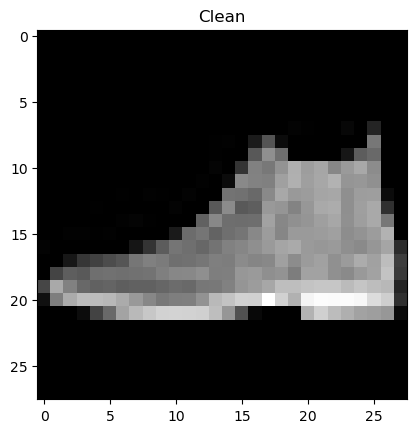

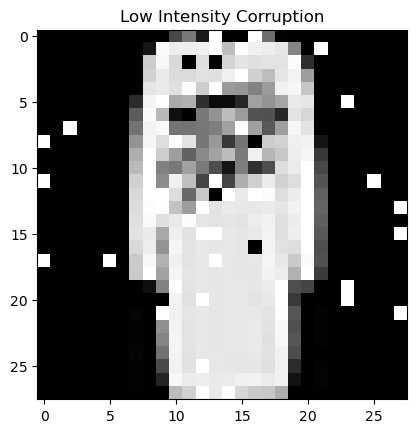

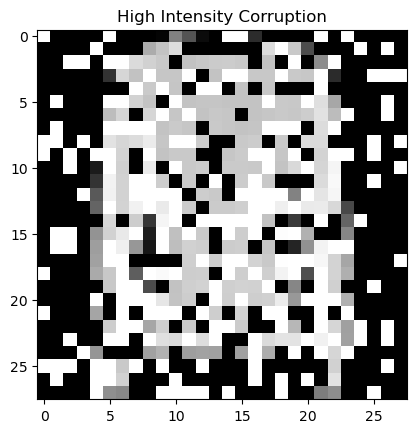

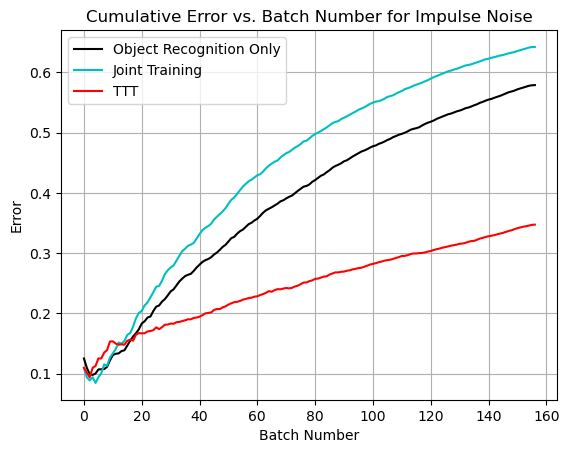

In [15]:
# Increasing impulse noise as batches come in
model_copy_ss = copy.deepcopy(model_ss)
ss_optimizing_params = list(model_copy_ss.shared_branch.parameters()) + list(model_copy_ss.ss_head.parameters())
optimizer = optim.SGD(ss_optimizing_params,lr=lr,momentum=0, weight_decay=0)

max_noise = .5
transformClass = ImpulseNoise

errors_joint = test_increasing_noise(loader,model_copy_ss,two_head=True,ttt=False,optimizer=optimizer,transformClass=transformClass,max_noise=max_noise)
errors_ttt = test_increasing_noise(loader,model_copy_ss,two_head=True,ttt=True,optimizer=optimizer,transformClass=transformClass,max_noise=max_noise)
errors_base = test_increasing_noise(loader,model_resnet,optimizer=optimizer,transformClass=transformClass,max_noise=max_noise,sample=True)

plt.plot(errors_base,color='k')
plt.plot(errors_joint,color='c')
plt.plot(errors_ttt,color='r')
plt.legend(["Object Recognition Only","Joint Training","TTT"])
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.title("Cumulative Error vs. Batch Number for Impulse Noise")
plt.grid(True)
plt.show()

Based on the plots, we can look at the slope of the cumulative error and see that for both Gaussian and Impulse noise, TTT has a much lower change in error as the noise increases compared to the baseline and joint training. This makes sense as we expect the model to adapt to the noise as it slowly increases. It isn’t perfect but TTT clearly helps a lot under a shifting distribution.

The next experiment compared the errors between each of the corruptions at high intensities. Unlike the last section, the errors are computed on a static corruption level, so no varying it over time. The models were trained on clean, data augmented images and I expect the TTT to do better overall on anything that isn’t the original dataset. I also included some sample images to help us understand what kind of noise is being added.

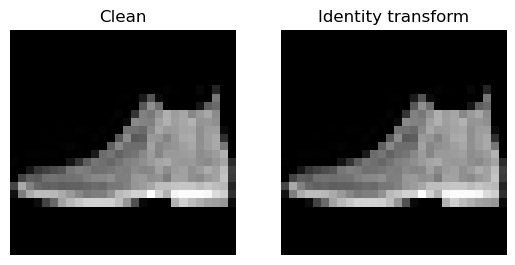

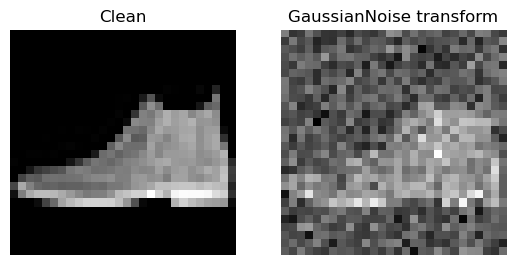

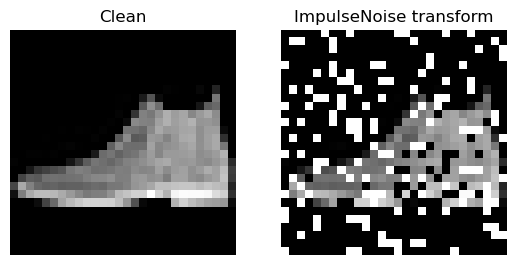

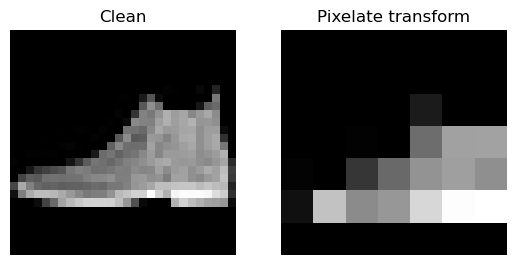

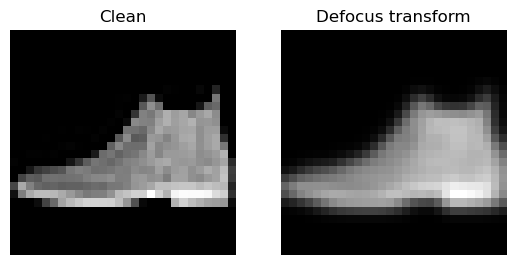

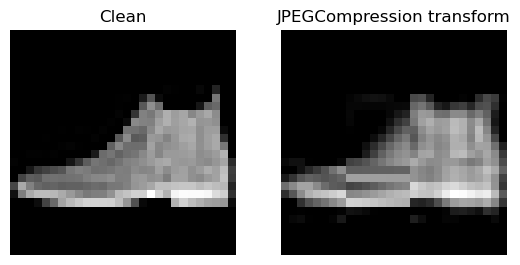

In [16]:
# Visualize transforms and get accuracy of classifiers on noisy data
transform_list = [Identity,GaussianNoise,ImpulseNoise,Pixelate,Defocus,JPEGCompression]
accuracy_per_classifier = []

for noiseTransform in transform_list:
    model_copy_ss = copy.deepcopy(model_ss)
    ss_optimizing_params = list(model_copy_ss.shared_branch.parameters()) + list(model_copy_ss.ss_head.parameters())
    optimizer = optim.SGD(ss_optimizing_params,lr=lr,momentum=0, weight_decay=0)
    
    noise_transform = noiseTransform()
    acc_base = check_accuracy(loader,model_resnet,printing=False,transform=noise_transform)
    acc_joint = check_accuracy(loader,model_copy_ss,two_head=True,printing=False,transform=noise_transform)
    acc_ttt = check_accuracy(loader,model_copy_ss,two_head=True,ttt=True,printing=False,transform=noise_transform,optimizer=optimizer)
    
    accuracy_per_classifier.append((acc_base,acc_joint,acc_ttt))

    # Display example image
    x,_ = next(iter(loader))
    img = x[0]
    noisy_img = noise_transform(img)
    img = img.squeeze()
    noisy_img = noisy_img.squeeze()
    
    fig, ax = plt.subplots(1, 2)  # 1 row, 2 columns
    ax[0].imshow(img,cmap='gray')
    ax[0].axis('off')
    ax[0].set_title("Clean")

    ax[1].imshow(noisy_img,cmap='gray')
    ax[1].axis('off')
    ax[1].set_title(f"{noiseTransform.__name__} transform")
    plt.show()
    
accuracy_per_classifier = np.array(accuracy_per_classifier)

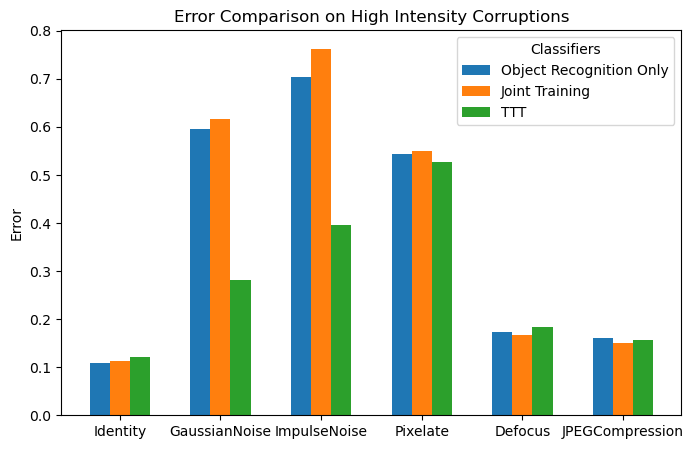

In [17]:
# Plot error each classifier has on high intensity noise
errors_per_classifier = 1 - accuracy_per_classifier
categories = [Class.__name__ for Class in transform_list]  # c categories
results = ['Object Recognition Only','Joint Training', 'TTT']  # n results per category

x = np.arange(len(categories))
width = 0.2

fig, ax = plt.subplots(figsize=(8, 5))

# Plot each result as a separate bar within each category
for i, result in enumerate(results):
    ax.bar(x + i * width, errors_per_classifier[:, i], width, label=result)  

ax.set_xticks(x + width)  # Center labels
ax.set_xticklabels(categories)
ax.set_ylabel('Error')
ax.set_title('Error Comparison on High Intensity Corruptions')
ax.legend(title='Classifiers')

plt.show()

### Conclusion
The results suggest that TTT is a very strong improvement for some types of corruption, while weak or functionally identical to other types of corruption. Specifically, Gaussian and Impulse noise are both much less erroneous with TTT and joint training is slightly worse than our baseline. For the others, the classifiers are all roughly the same. Although TTT is a powerful method that allows models to improve robustness against noise, this implementation is not perfect. But this demonstrates the power of self-supervised learning at test-time and how it can be used to improve existing models even when training data is limited, being a potential solution to the limitations of supervised learning models.